### Investigating use of KF to recover parameters

In [16]:
import os
from ModularCirc.Models.KorakianitisMixedModel import KorakianitisMixedModel, KorakianitisMixedModel_parameters, TEMPLATE_TIME_SETUP_DICT
from ModularCirc import BatchRunner
import numpy as np
import pandas as pd
from cvdnet_pipeline.utils import helper_functions, plot_utils


1. Sample parameters, 100 beats, pat.r gradually increasing/step function

In [17]:
# Setup
param_path = "../input_parameters_jsons/parameters_sensitive_pca123_9.JSON"
output_path = "../output_synthetic"
n_samples = 100
repeat_simulations = True

# Define parameter changes
changes = {
    "pat.r": {"start": 0.3, "step": 0.1},        # start at 0.3, increase 0.1 every 20 rows to 0.8
    "pat.c": {"start": 3.8, "step": -0.1},       # start at 3.8, decrease -0.1 every 20 rows to 3.3
    "ti.CQ": {"start": 400, "step": 1},          # start at 400, increase 1 every 20 rows to 405
    "rv.E_pas": {"start": 0.7, "step": 0.1},     # start at 0.7, increase 0.1 every 20 rows to 1.2
    "rv.E_act": {"start": 1.2, "step": -0.1},    # start at 1.2, decrease -0.1 every 20 rows to 0.7
    "rv.k_pas": {"start": 0.015, "step": 0.01},  # start at 0.015, increase 0.01 every 20 rows to 0.065
    "ra.E_act": {"start": 0.25, "step": -0.01},  # start at 0.25, decrease -0.01 every 20 rows to 0.20
    "ra.k_pas": {"start": 0.015, "step": 0.01}   # start at 0.015, increase 0.01 every 20 rows to 0.065
}

# Sample parameters or read in from file
br = BatchRunner('Sobol', 0)
br.setup_sampler(param_path)
br.sample(n_samples)




/Users/pmzff/Documents/GitHub/cvd-net-pipeline/cvd-net-pipeline/venv/lib/python3.13/site-packages/ModularCirc/_BatchRunner.py:59: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  samples  = self._sampler.random(nsamples)


In [18]:
def alter_br_samples(df, changes):
    updated = df.copy()
    
    for col, opts in changes.items():
        start = opts["start"]
        step = opts["step"]
        
        values = []
        for i in range(len(updated)):
            block = i // 20  # every 20 rows
            values.append(start + (block * step))
        
        updated[col] = values
    
    return updated

br._samples = alter_br_samples(br._samples, changes)


2. Simulate beats

In [19]:
# Get relevant columns  
relevant_columns = [col for col in br._samples.columns if col in br._parameters_2_sample.keys()]
_pure_samples = br._samples[relevant_columns].copy()

map_ = {
        'delay': ['la.delay', 'ra.delay'],
        'td0': ['lv.td0', 'rv.td0'],
        'tr': ['lv.tr', 'rv.tr'],
        'tpww': ['la.tpww', 'ra.tpww'],
    }
    
br.map_sample_timings(
    ref_time=1.,
    map=map_
)

br._samples[['lv.td', 'rv.td']] = br._samples[['lv.tr', 'rv.tr']].values + br._samples[['lv.td0', 'rv.td0']].values
br._samples.drop(['lv.td0', 'rv.td0'], axis=1, inplace=True)

# get relevant columns and count them
n_params = len(relevant_columns)
br.map_vessel_volume()

br.setup_model(model=KorakianitisMixedModel, po=KorakianitisMixedModel_parameters,
                time_setup=TEMPLATE_TIME_SETUP_DICT)

file_suffix  = f'_{n_samples}_{n_params}_params'

# Save samples as CSV files 
_pure_samples.to_csv(os.path.join(output_path, f'pure_input{file_suffix}.csv'), index=False)
br.samples.to_csv(os.path.join(output_path, f'input{file_suffix}.csv'), index=False)

output_parameters = os.path.join(output_path, f'output{file_suffix}')
output_parameters_simulations = os.path.join(output_parameters,'simulations')


# Check if the directory exists and contains n_samples files
if os.path.exists(output_parameters_simulations) and len(os.listdir(output_parameters_simulations)) >= n_samples and repeat_simulations==False:
    print(f"Skipping simulation as {output_parameters} already contains {n_samples} or more files.")
    # read a list of dataframes from here
    simulations = helper_functions.load_simulation(output_parameters_simulations)

    if len(simulations) != n_samples:
        raise ValueError(f"Expected {n_samples} simulations, but found {len(simulations)}. Will run simulations again.")
        repeat_simulations = True
else:
    print(f"Running simulation as {output_parameters}.")
    repeat_simulations = True


if repeat_simulations:
    os.makedirs(output_parameters_simulations, exist_ok=True)
    simulations = br.run_batch(
        n_jobs=7,
        output_path=output_parameters_simulations
    )

Running simulation as ../output_synthetic/output_100_9_params.


100%|██████████| 100/100 [00:37<00:00,  2.69it/s]


No boolean values found in the list.


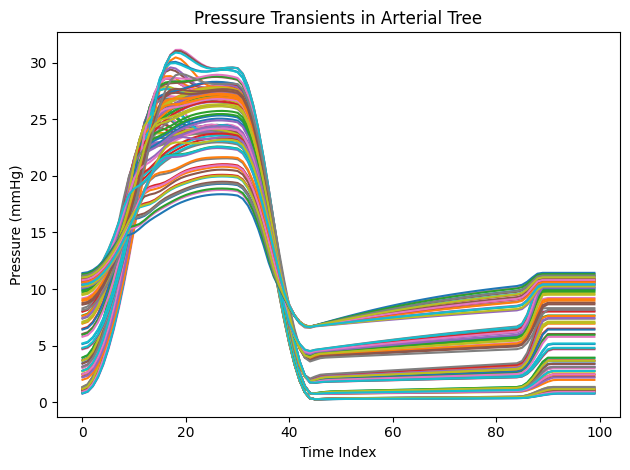

In [20]:
# Check for bool values in the list
bool_indices = [index for index, value in enumerate(simulations) if isinstance(value, bool)]

if bool_indices:
    print(f"Boolean values found at indices: {bool_indices}")
    print(f"Number of Booleans = {len(bool_indices)}")
else:
    print("No boolean values found in the list.")


helper_functions.save_csv(pd.DataFrame(bool_indices), os.path.join(output_parameters, f'bool_indices_{n_samples}.csv'))

# plot simulated traces
plot_utils.plot_simulated_traces(simulations, output_path=output_parameters)

pressure_traces_df_pat, pressure_traces_df_rv = helper_functions.select_feasible_traces(simulated_traces=simulations, output_path=output_parameters)

# Save the DataFrame to a single CSV file with headers
helper_functions.save_csv(pressure_traces_df_pat, f'{output_parameters}/pressure_traces_pat/all_pressure_traces.csv')
helper_functions.save_csv(pressure_traces_df_rv, f'{output_parameters}/pressure_traces_rv/all_pressure_traces.csv')

plot_utils.plot_pressure_transients_arterial_tree(pressure_traces_df_rv, output_parameters)
